As a general remark, I am running python 3.7.6 so I cannot use dict union logic like what was presented in the notebook from task 2, or other more recently introduced pythonic stuff like the walrus operator

In [84]:
!pip install --user scikit-image

     |████████████████████████████████| 55.4 MB 18.7 MB/s eta 0:00:01     |████████████████████████████████| 55.4 MB 20 kB/s 
     |████████████████████████████████| 3.3 MB 83.4 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 84.8 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/mnt/storage/asopio/conda/envs/gpu02_conda/bin/python -m pip install --upgrade pip' command.


In [1]:
import pickle
import gzip
import numpy as np
import os, os.path
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import skimage.util
import scipy.spatial.distance as spdist
from PIL import Image

Helper functions

In [88]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object
    
def get_whole_floor(n,near):
    """
    this just gives the nearest divisor modulo zero to a number given a guess
    """
    nn = np.divide(n,np.linspace(np.floor(n/near),n,int(n-np.floor(n/near)+1)))
    return int(nn[nn%1==0][0])

def _are_inconsistent(mask1, mask2):
    has_mask1 =  np.count_nonzero(mask1) > 0
    has_mask2 =  np.count_nonzero(mask2) > 0
    return has_mask1 != has_mask2

def compute_img_hist(img):
    # Divide the image in blocks and compute per-block histogram
    block_shape_w = get_whole_floor(img.shape[0], 10)
    block_shape_h = get_whole_floor(img.shape[1], 10)
    blocks = skimage.util.view_as_blocks(img, block_shape=(block_shape_w, block_shape_h))
    img_hists = [np.histogram(block, bins=np.linspace(0, 1, 10))[0] for block in blocks]
    return np.concatenate(img_hists)

def _filter_inconsistent(imgs, masks):
    hists = np.array(list(map(compute_img_hist, imgs)))
    dists = spdist.squareform(spdist.pdist(hists, metric='cosine'))
    
    # find duplicates. +np.eye because we want to exclude image matching with itself.
    # I determined 0.0007 empirically
    close_pairs = dists + np.eye(dists.shape[0]) < 0.0007
    close_ij = np.transpose(np.nonzero(close_pairs))
    # Find inconsistent masks among duplicates
    valids = np.zeros(len(imgs), dtype=np.bool)
    for i, j in close_ij:
        if _are_inconsistent(masks[i], masks[j]):
            valids[i] = valids[j] = True
    
    return np.array(imgs)[valids], np.array(masks)[valids], valids

def _filter_consistent(imgs, masks):
    hists = np.array(list(map(compute_img_hist, imgs)))
    dists = spdist.squareform(spdist.pdist(hists, metric='cosine'))
    
    # find duplicates. +np.eye because we want to exclude image matching with itself.
    # I determined 0.0007 empirically
    close_pairs = dists + np.eye(dists.shape[0]) < 0.01
    close_ij = np.transpose(np.nonzero(close_pairs))
    # Find inconsistent masks among duplicates
    valids = np.ones(len(imgs), dtype=np.bool)
    for i, j in close_ij:
        if _are_inconsistent(masks[i], masks[j]):
            valids[i] = valids[j] = False
    
    return np.array(imgs)[valids], np.array(masks)[valids], valids

def plot_image_with_mask(img, mask, box, title=None):
    """
    this does the same thing as plot_separate but plots only the overlayed img
    """
    # returns a copy of the image with edges of the mask added in red
    img_mask = np.ma.masked_where(mask == False, mask)
    img_box = np.ma.masked_where(box == False, box)
    #plt.figure(figsize=(8,8))
    plt.imshow(img, cmap = 'gray', interpolation = 'none')
    plt.imshow(img_mask, cmap = 'jet', interpolation = 'none', alpha = 0.8)
    plt.imshow(img_box, cmap = 'spring', interpolation = 'none', alpha = 0.5)
    plt.title(title)

def mask_not_blank(mask):
    return sum(mask.flatten()) > 0

def grays_to_RGB(img):
    # turn image into grayscale RGB
    return np.array(Image.fromarray(img).convert("RGB"))

def plot_image(img, title=None):
    plt.figure(figsize=(7,7))
    plt.title(title)
    plt.imshow(img)
    plt.show()

def plot_separate(img, mask, box, typeof_ds):
    fig, axs = plt.subplots(1, 4, figsize=(20, 12))
    img_mask = np.ma.masked_where(mask == False, mask)
    img_box = np.ma.masked_where(box == False, box)
    axs[0].set_title(f"Ultrasound from {typeof_ds} dataset")
    axs[0].imshow(img)
    axs[1].set_title("Mask")
    axs[1].imshow(mask, cmap='gray')
    axs[2].set_title("Box")
    axs[2].imshow(box, cmap='gray')
    axs[3].set_title("Ultrasound image with mask overlayed")
    
    axs[3].imshow(img, cmap = 'gray', interpolation = 'none')
    axs[3].imshow(img_box, cmap = 'spring', interpolation = 'none', alpha = 0.5)
    axs[3].imshow(img_mask, cmap = 'jet', interpolation = 'none', alpha = 0.8)
    #asp = img.shape[0] / img.shape[1]
    #axs[3].set_aspect(asp)
    
def explore_video(data, min_id, max_id):
    for data in tqdm(data[min_id:max_id], total=len(data[min_id:max_id])):
        annotated_frames = data['frames']
        imgs = data['video'].T
        box = np.array(data['box'])
        labels = data['label'].T
        typeof_ds = data['dataset']
        pacient = data['name']
        images_shown = 0 
        annotated_imgs = [(imgs[frame], labels[frame]) for frame in annotated_frames]
        for i, (ultrasound, mask) in enumerate(annotated_imgs):
            print(f'frame {annotated_frames[i]}')
            plot_separate(ultrasound, mask, box, typeof_ds)
            img = grays_to_RGB(ultrasound)
            plot_image(img, "Input image grayscaled")


loading data

In [4]:
train_data = load_zipped_pickle("data/train.pkl")

load the first 5 videos and plot the images with masks

  0%|          | 0/5 [00:00<?, ?it/s]

frame 41


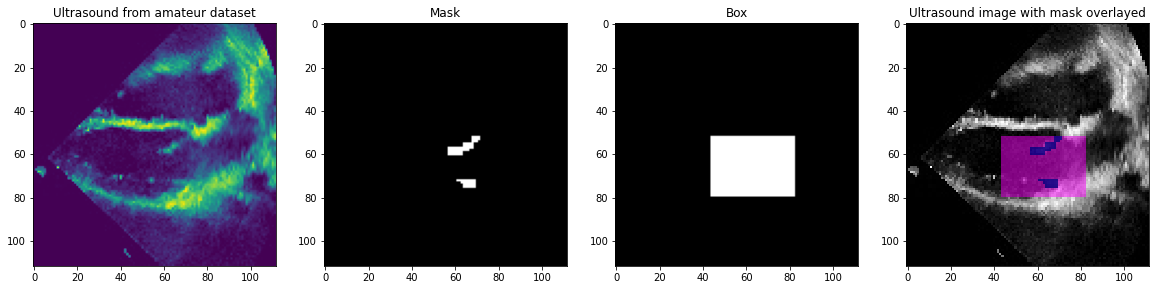

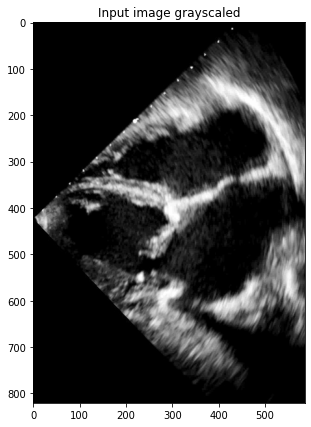

frame 65


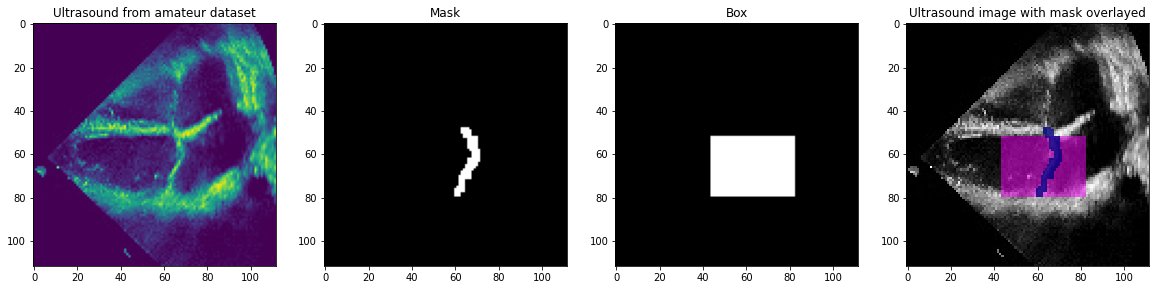

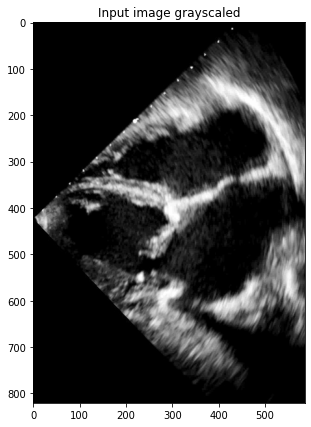

frame 167


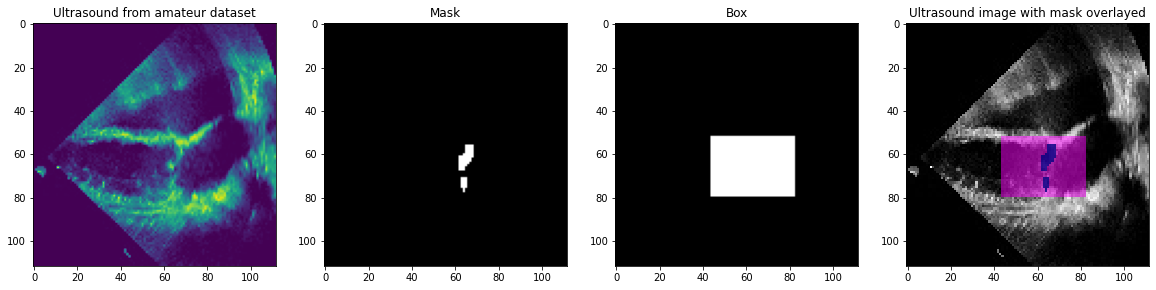

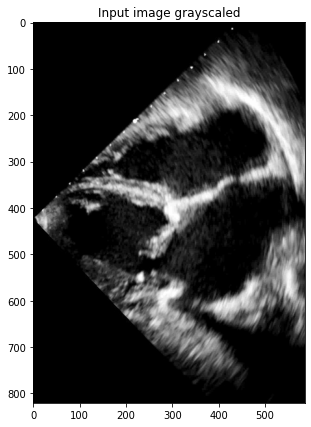

 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

frame 0


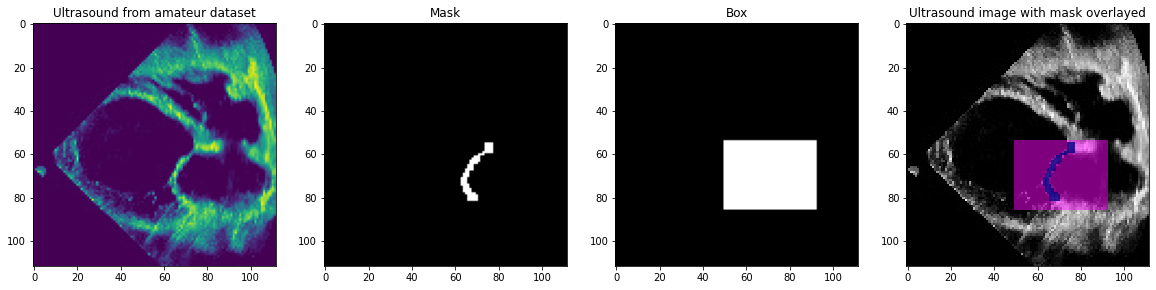

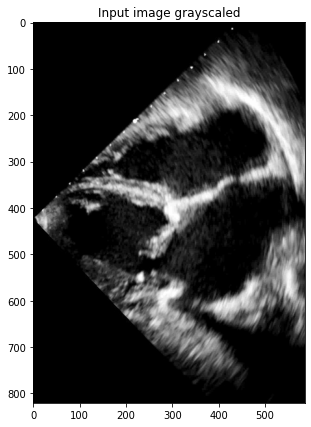

frame 77


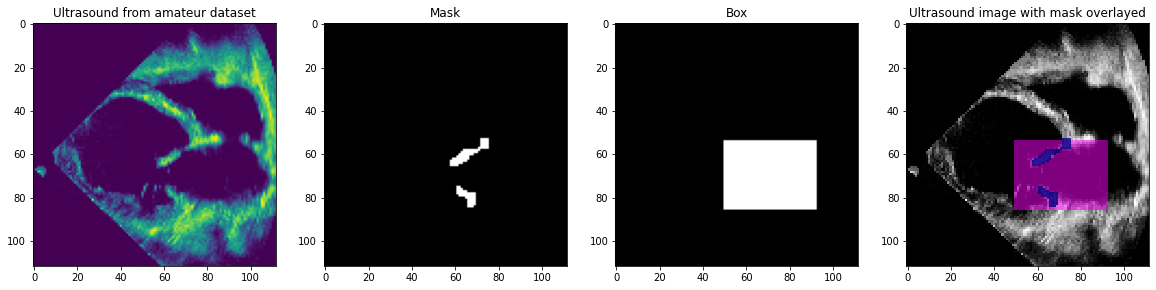

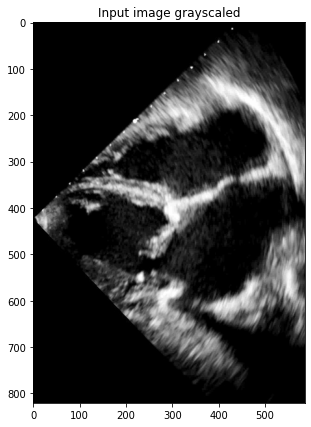

frame 134


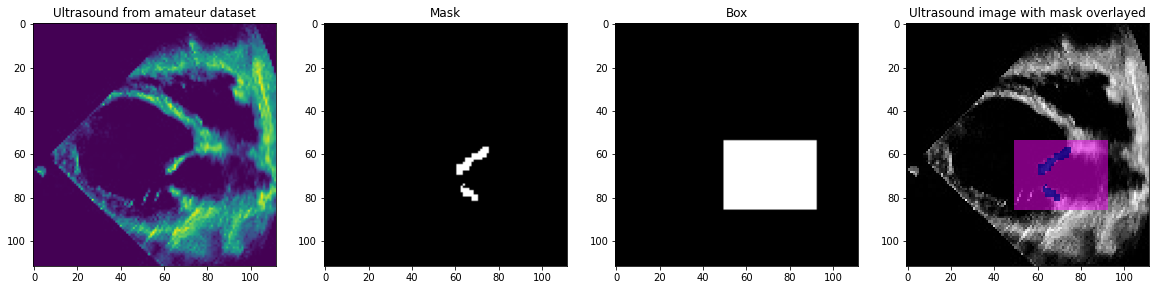

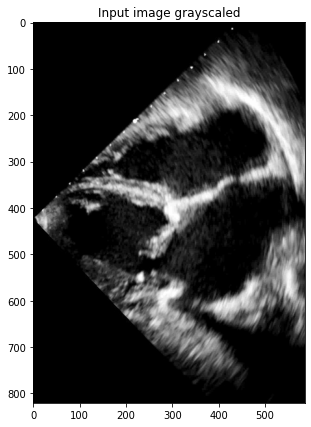

 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

frame 9


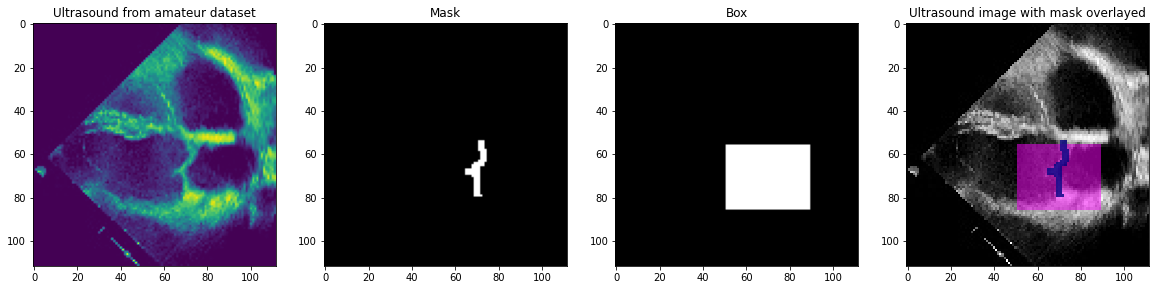

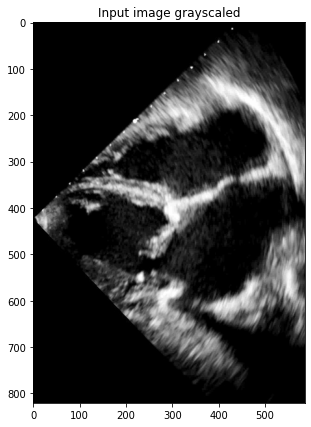

frame 86


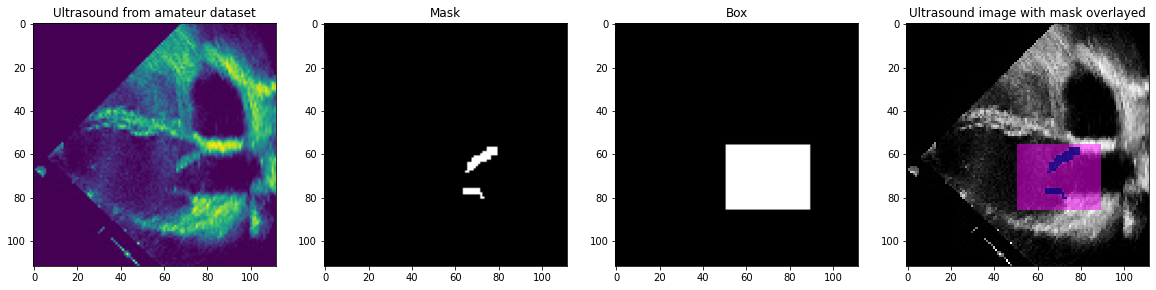

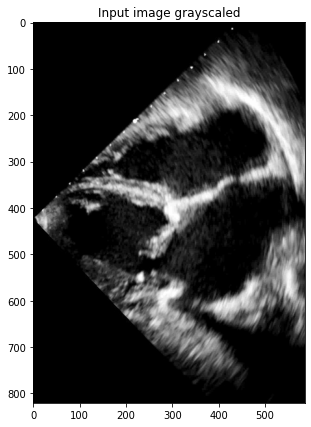

frame 121


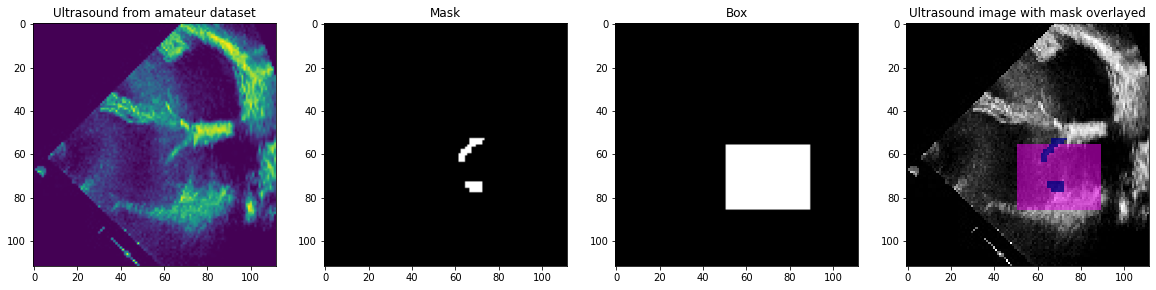

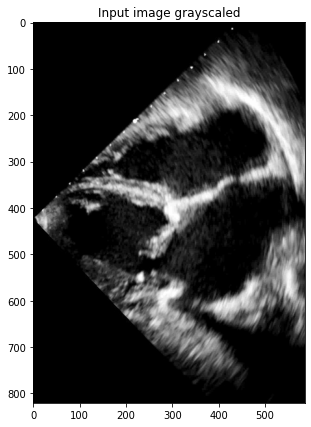

 60%|██████    | 3/5 [00:07<00:04,  2.46s/it]

frame 15


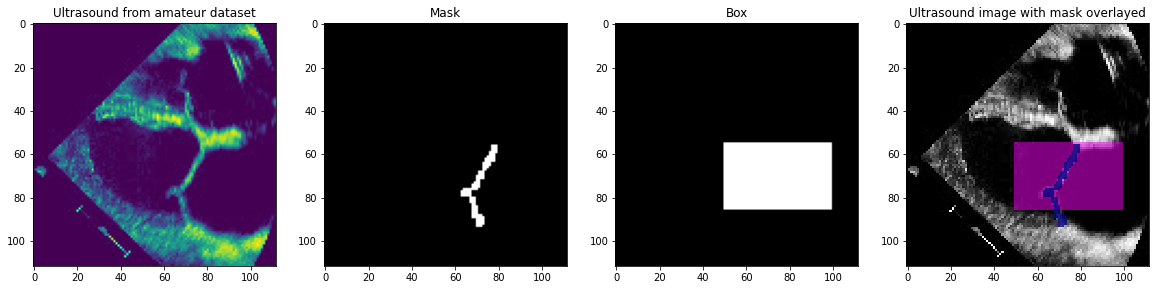

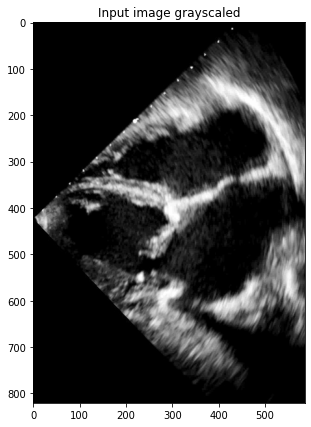

frame 58


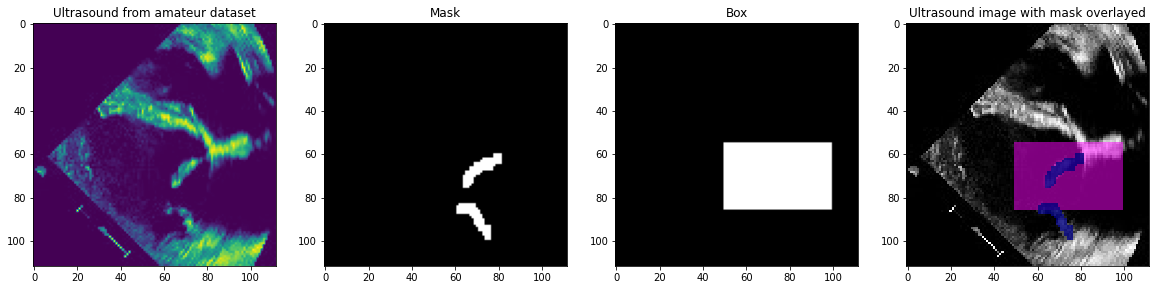

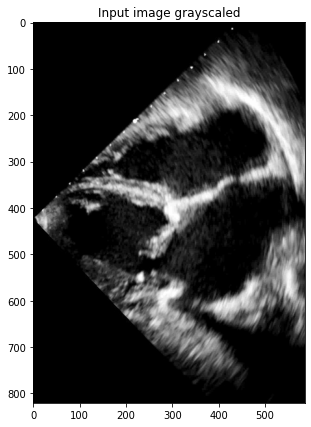

frame 122


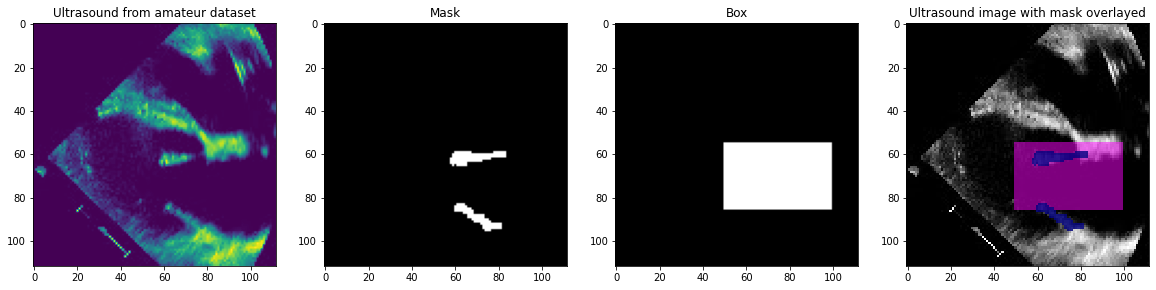

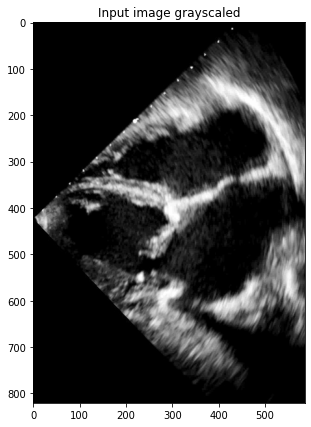

 80%|████████  | 4/5 [00:09<00:02,  2.40s/it]

frame 22


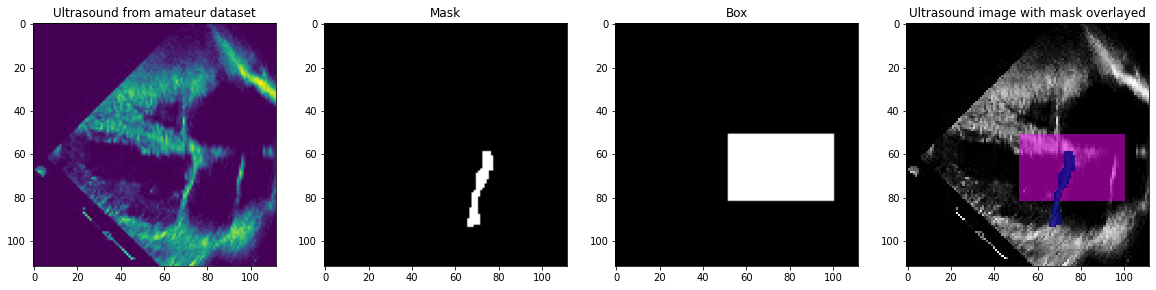

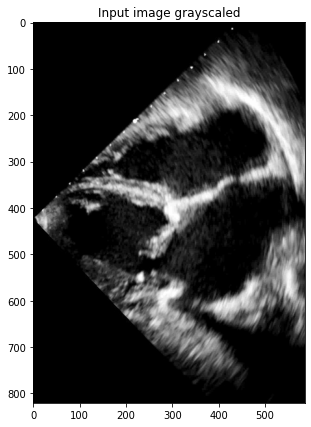

frame 51


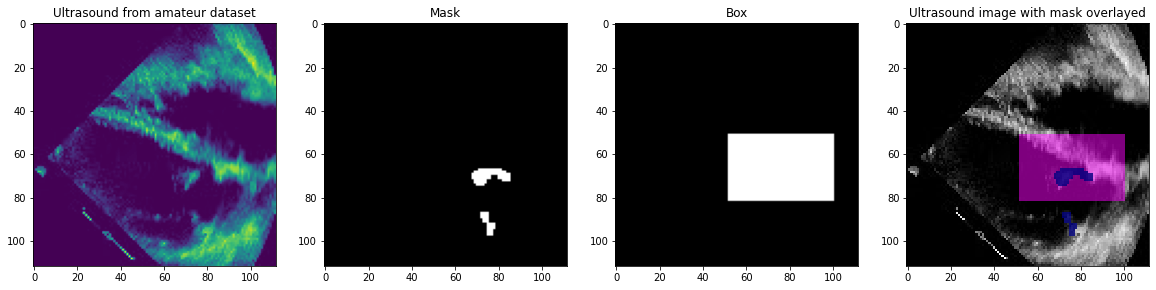

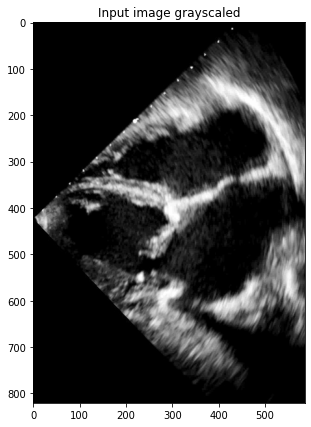

frame 129


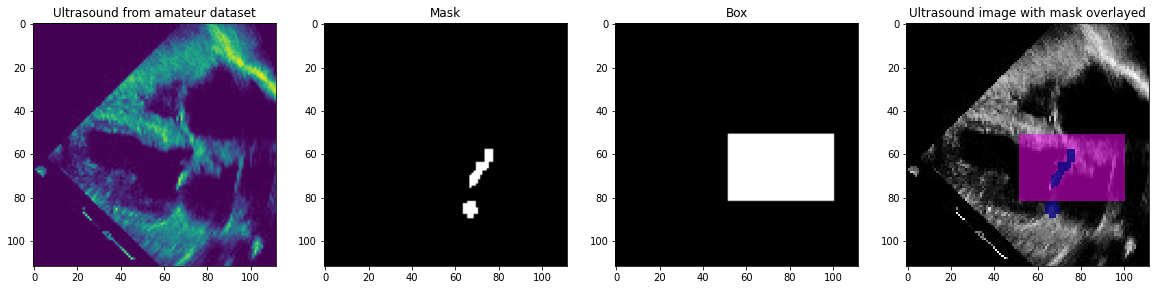

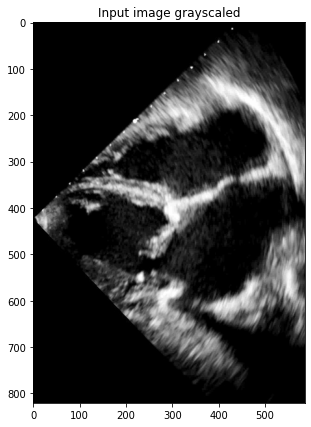

100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


In [231]:
explore_video(train_data, 0, 5)

Now the last 5

  0%|          | 0/5 [00:00<?, ?it/s]

frame 24


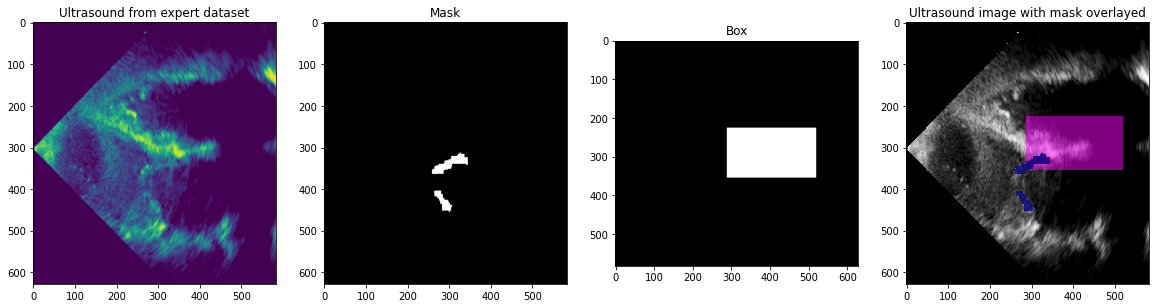

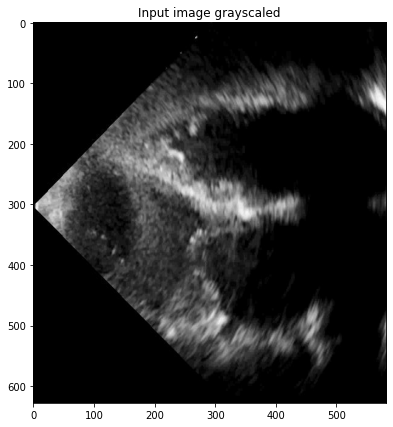

frame 57


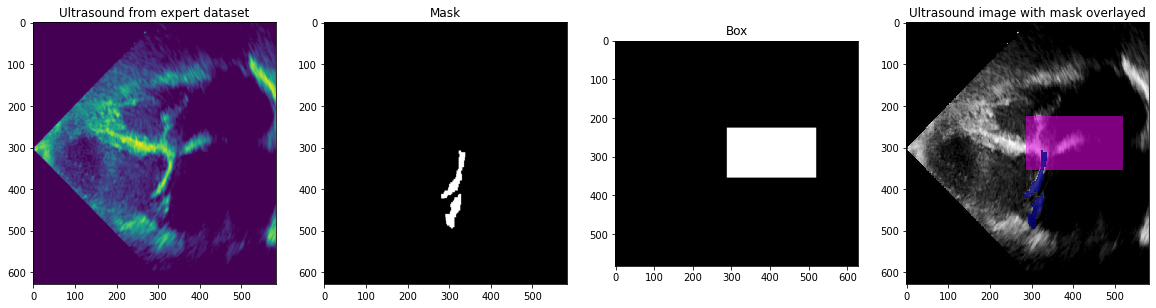

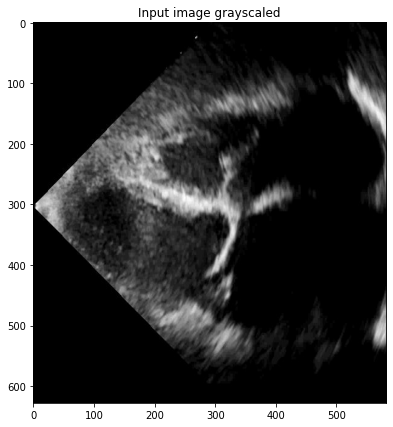

frame 72


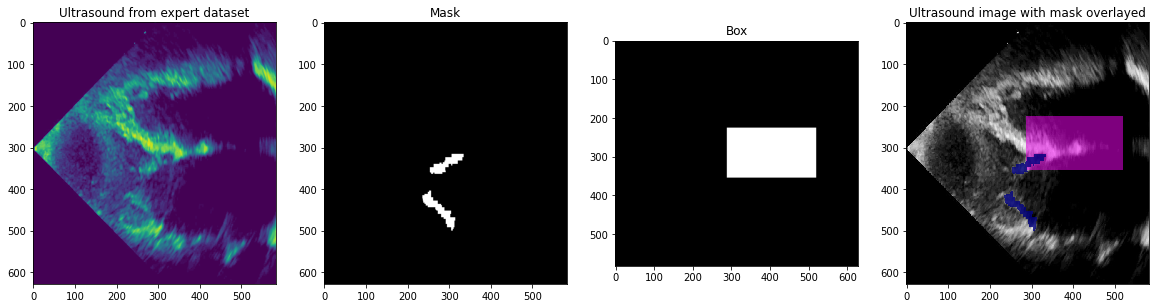

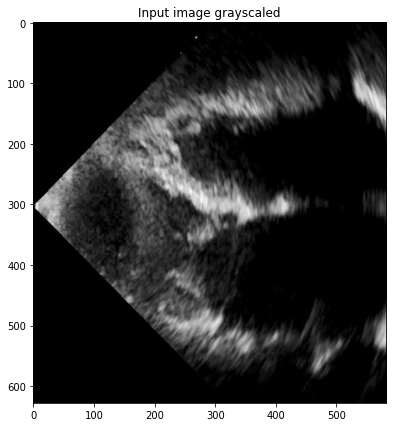

 20%|██        | 1/5 [00:02<00:11,  2.84s/it]

frame 9


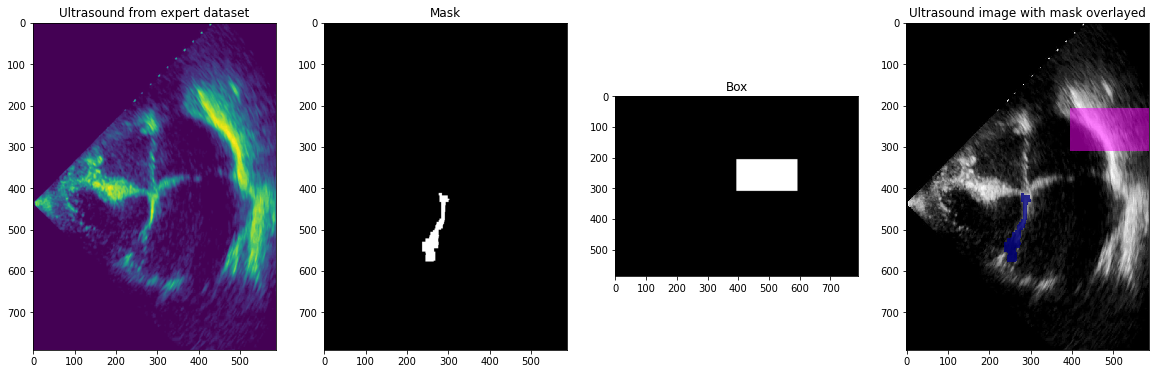

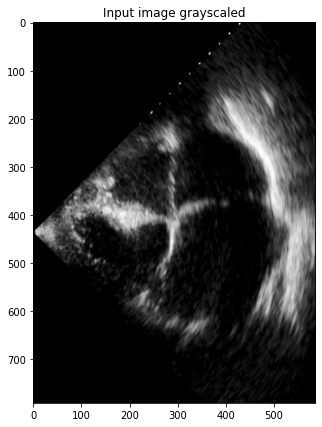

frame 28


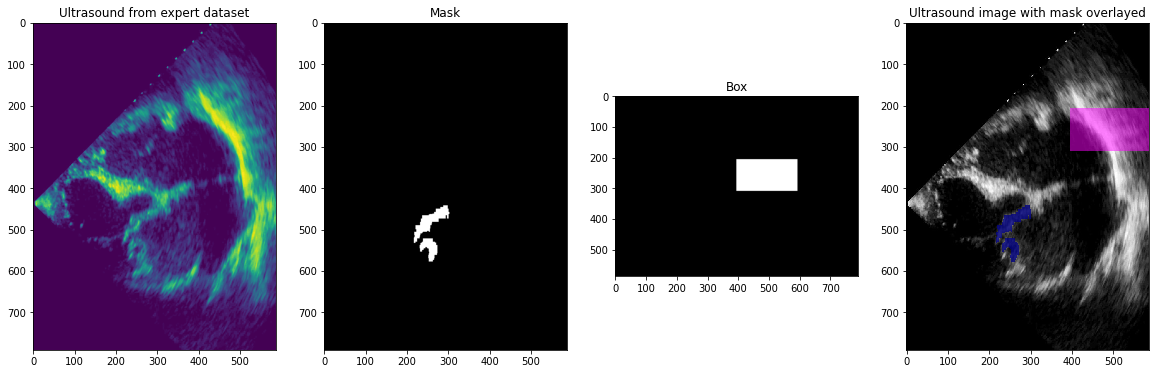

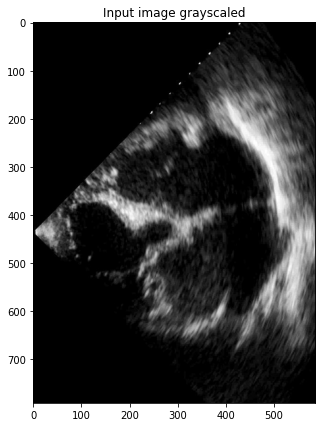

frame 47


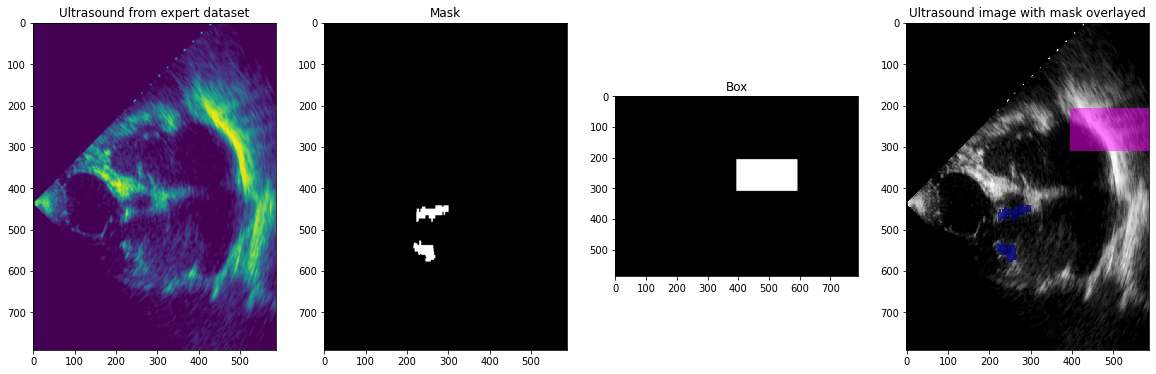

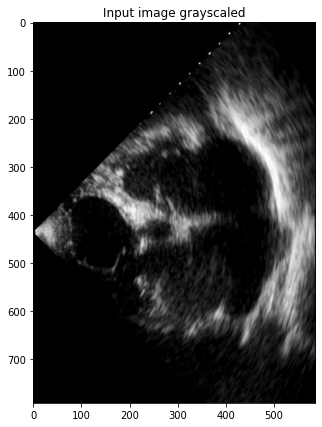

 40%|████      | 2/5 [00:06<00:09,  3.10s/it]

frame 21


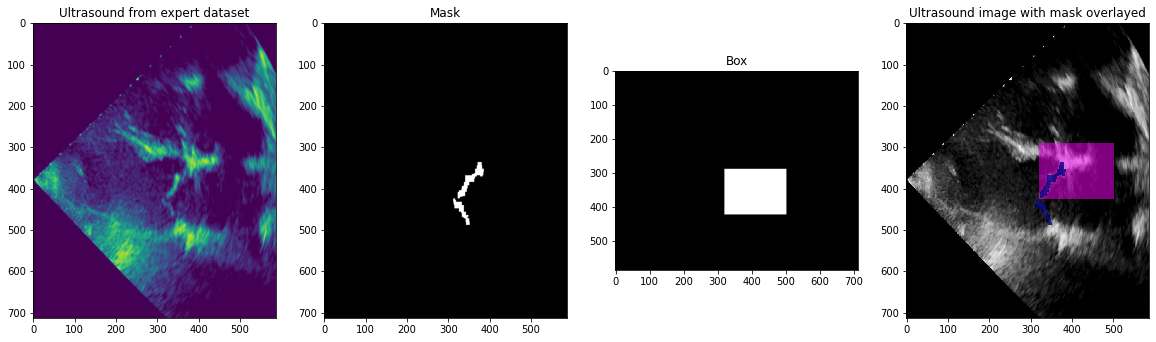

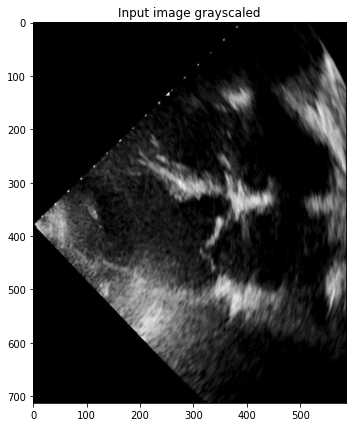

frame 26


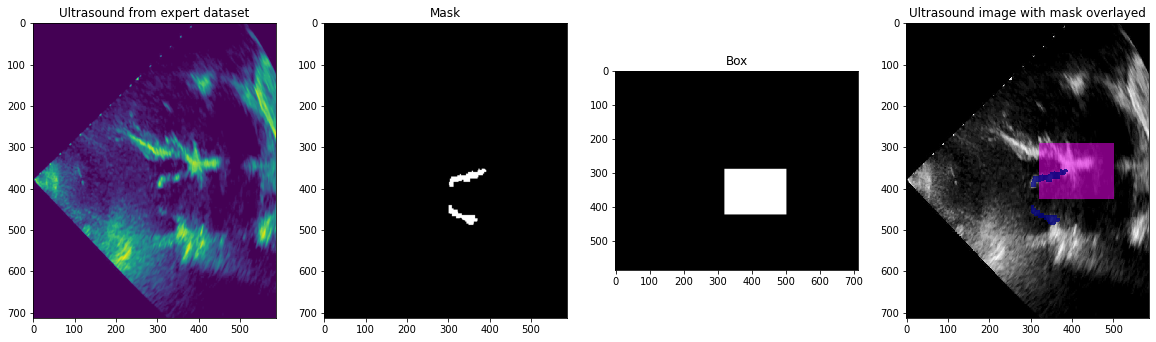

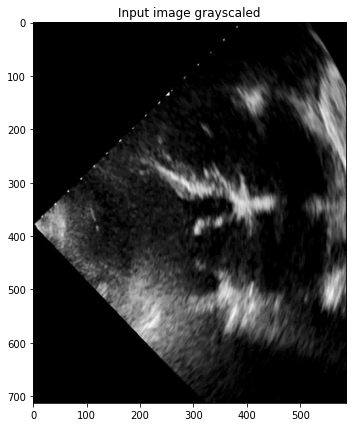

frame 44


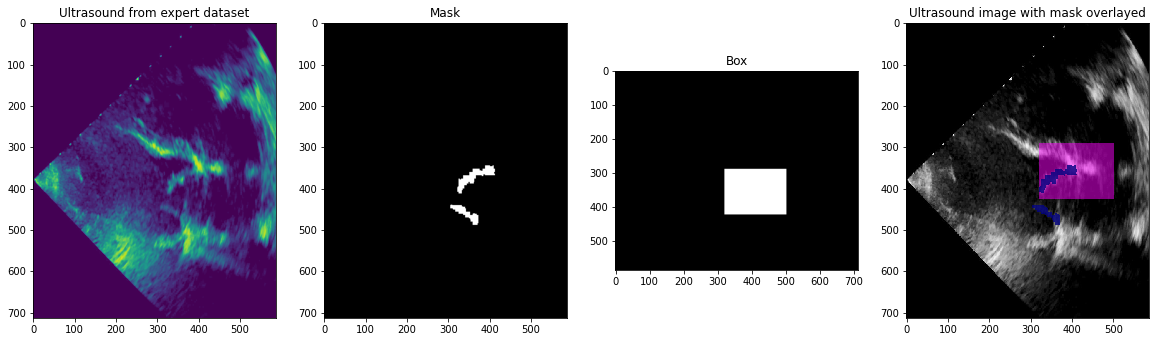

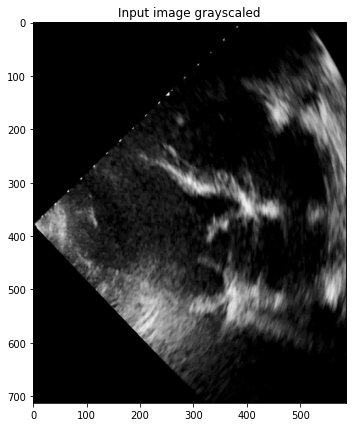

 60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

frame 2


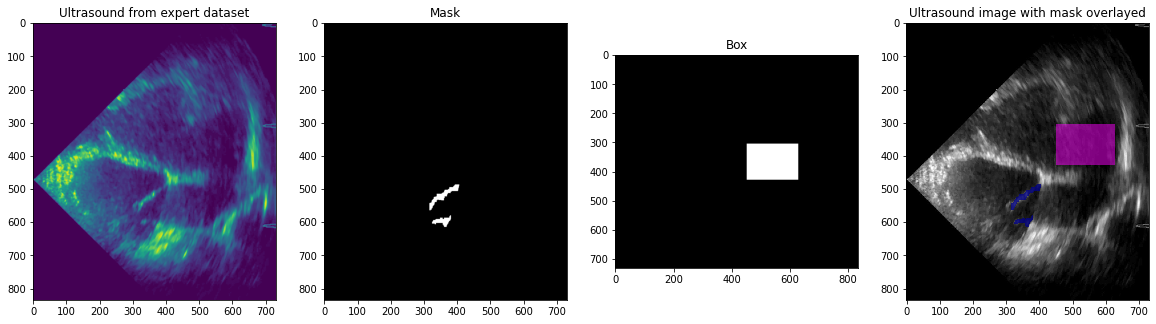

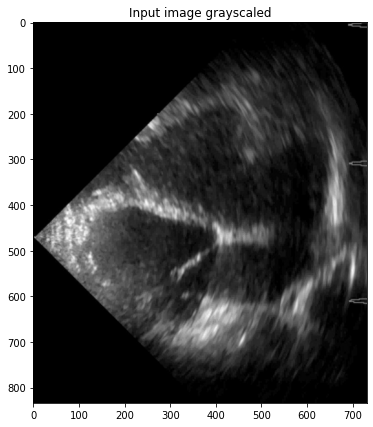

frame 7


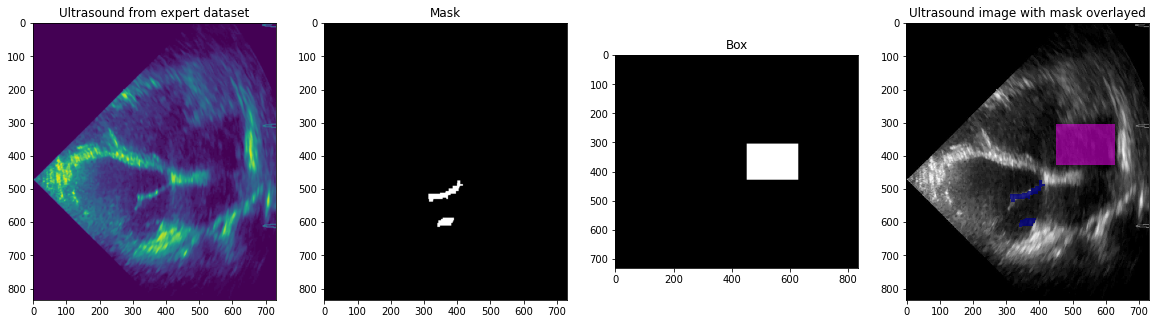

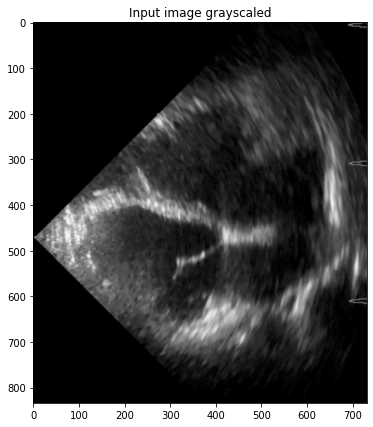

frame 13


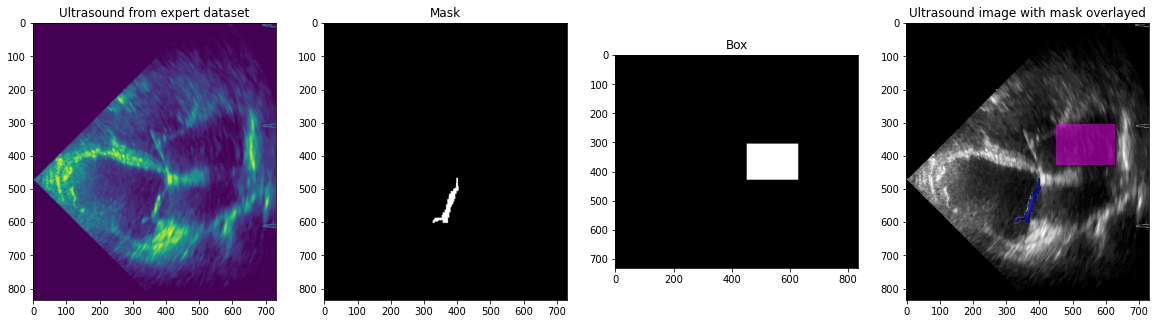

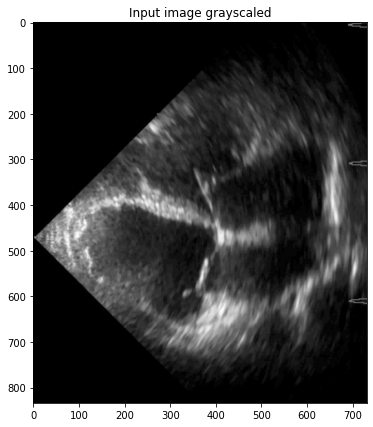

 80%|████████  | 4/5 [00:12<00:03,  3.30s/it]

frame 4


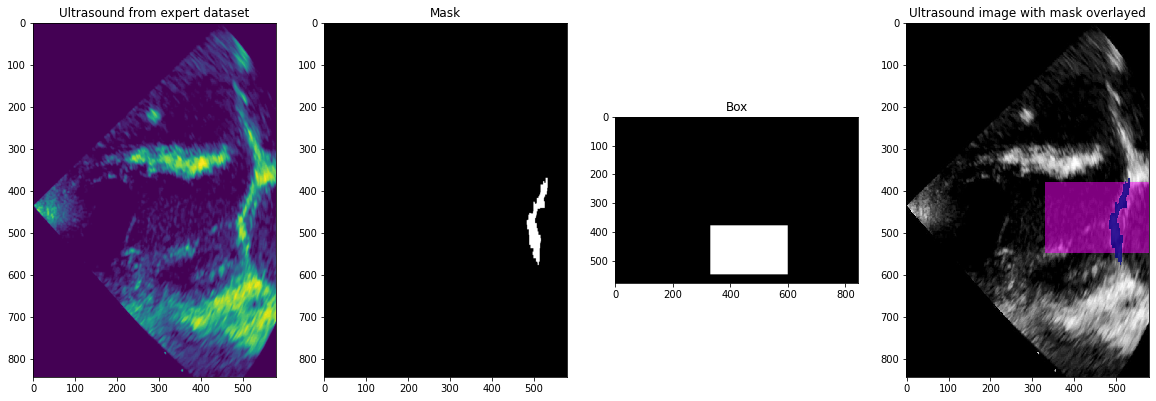

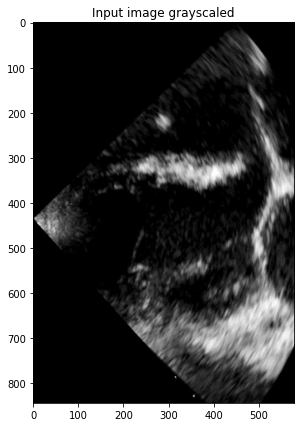

frame 31


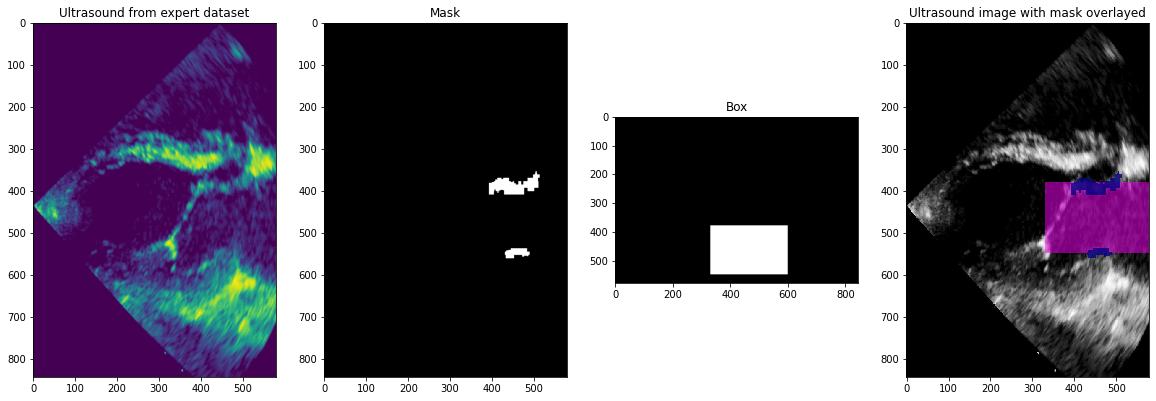

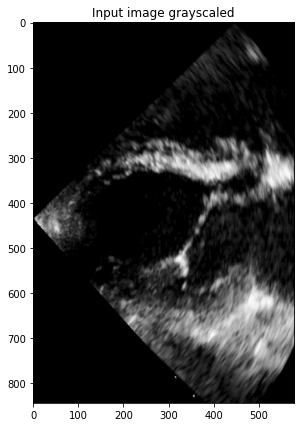

frame 54


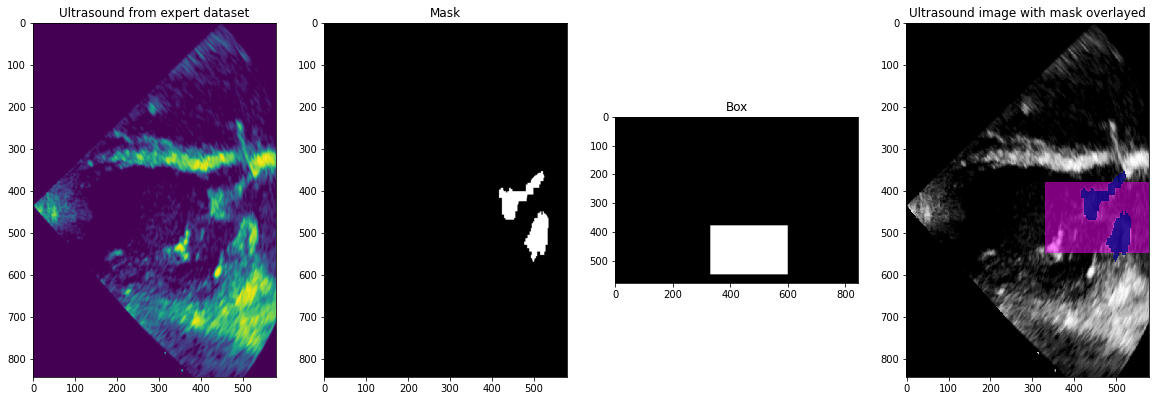

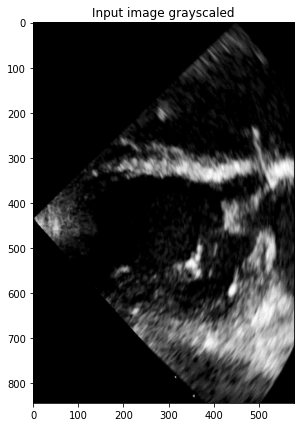

100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


In [87]:
explore_video(train_data, len(train_data)-5, len(train_data))

## Open questions:
1. What do we do for other frames which are not annotated? My intuition tells me either
    * to create empty masks for them or
    * compute some similarity measure between them and annotated frames to see if it makes sense to add more data
2. How can we use additional data about boxes in our models considering:
     1. Boxes don't fully overlap with masks
     2. Boxes **do not always contain** masks (it seems in the case of expert annotations)
     3. Boxes don't change position between frames
#### hence design of our network could incorporate data about the box (thinking about convolutions here) and uncertainty (predictions from this layer could be given some custom weights depeding on the typeof dataset - amateur or professional) 
3. Considering these are videos, do we have multiple very similar images with no mask?
4. What do we do about speckle noise? Would it make sense to apply some filters on the images to smooth out the noise?

### Data exploration: Compute image similarity in the first video

check if it makes sense to compute image similarity: how do frames right before and after annotation look?

  0%|          | 0/65 [00:00<?, ?it/s]

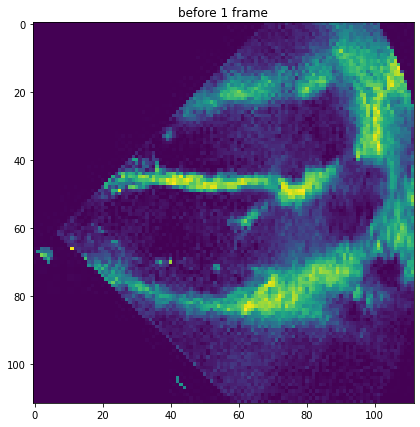

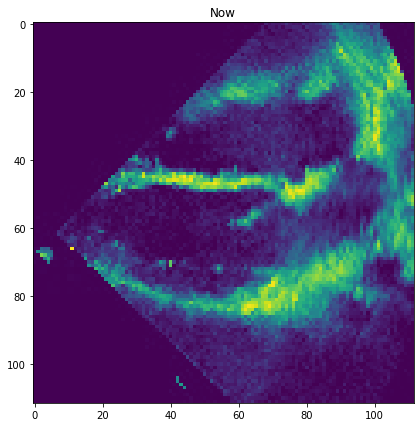

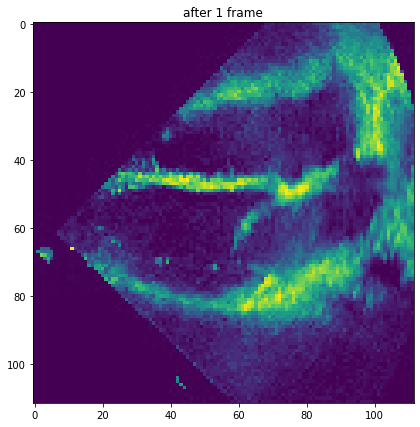

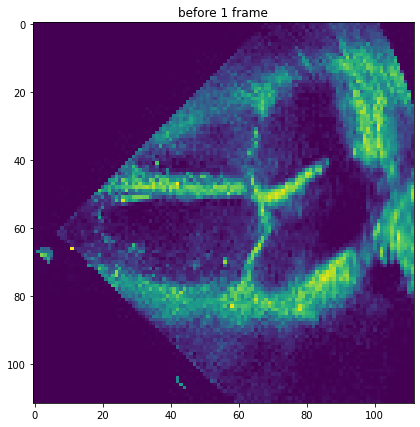

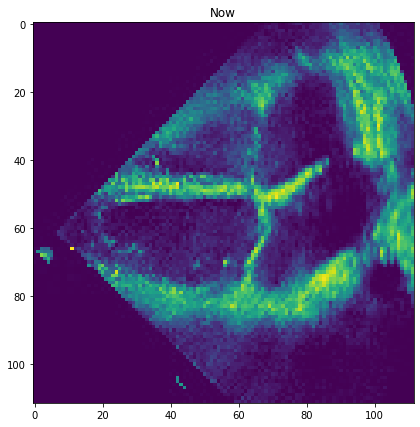

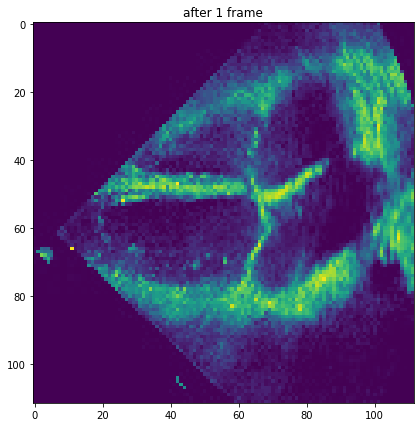

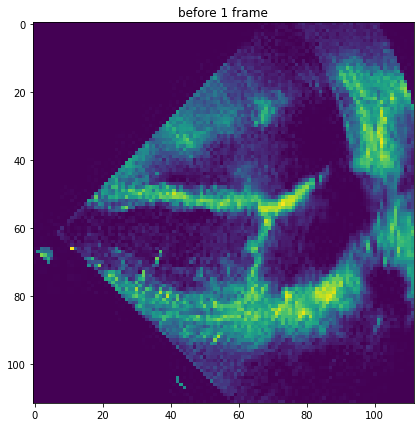

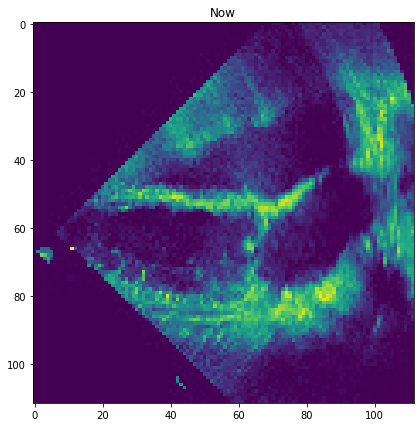

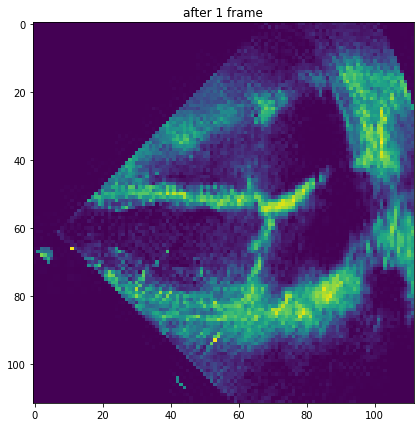

  0%|          | 0/65 [00:01<?, ?it/s]


In [457]:
for data in tqdm(train_data, total=len(train_data)):
    annotated_frames = data['frames']
    imgs = data['video'].T
    box = np.array(data['box'])
    labels = data['label'].T
    typeof_ds = data['dataset']
    pacient = data['name']
    images_shown = 0
    annotated_imgs = [(imgs[frame], labels[frame]) for frame in annotated_frames]
    [(plot_image(imgs[idx-1], 'before 1 frame'),
      plot_image(imgs[idx], "Now"),
      plot_image(imgs[idx-2], "after 1 frame"))
     for idx in annotated_frames]
    
    break

Might make sense to artificially annotate these as well. Let's compute a similarity measure between all images, and see which ones are similar "enough" to annotated images

  0%|          | 0/65 [00:00<?, ?it/s]

Validated 11 out of 3 from patient DY7ASN54S9


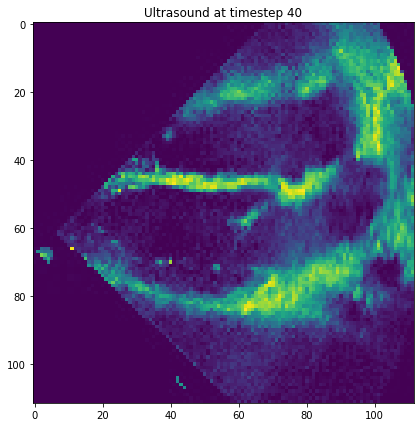

Frame is annotated


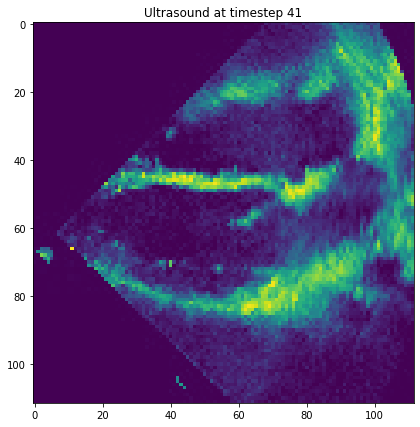

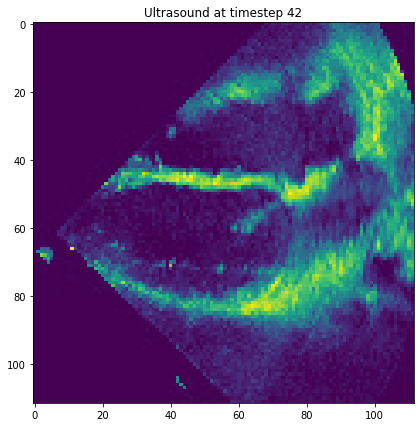

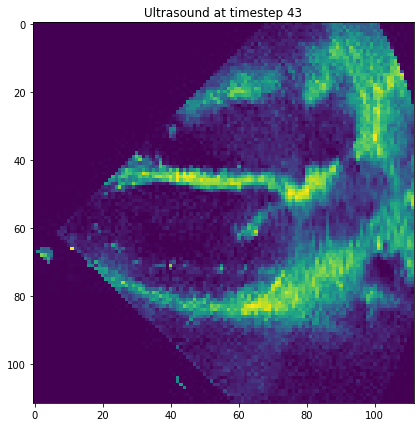

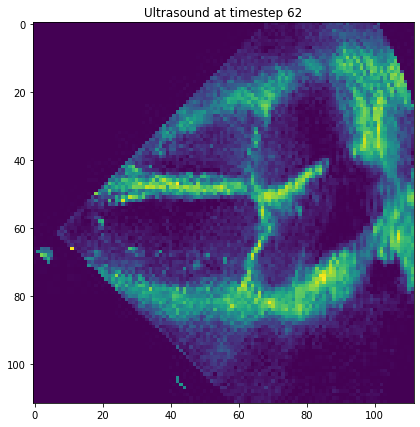

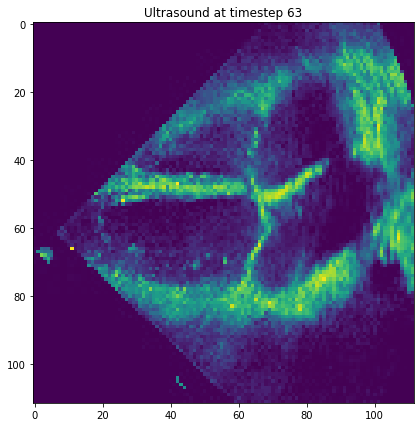

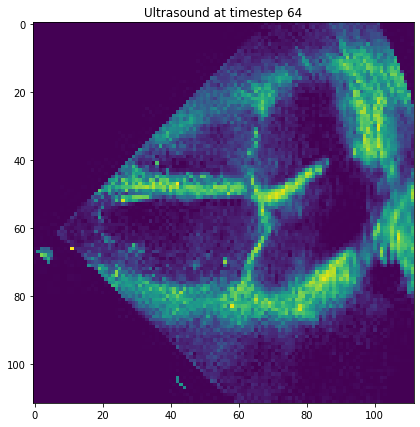

Frame is annotated


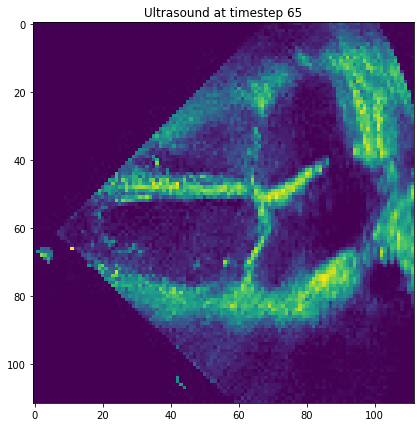

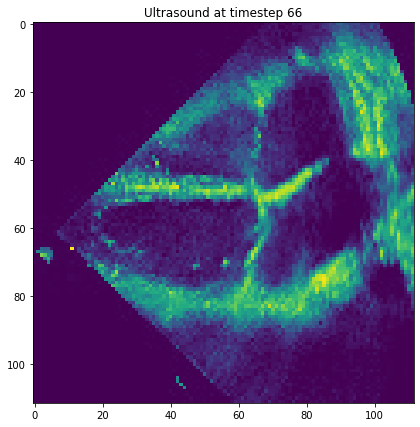

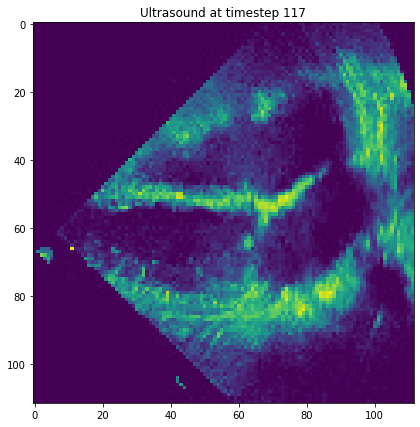

Frame is annotated


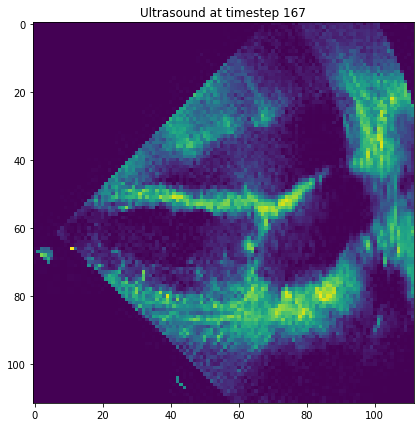

  0%|          | 0/65 [00:02<?, ?it/s]


In [511]:
for data in tqdm(train_data, total=len(train_data)):
    annotated_frames = data['frames']
    imgs = data['video'].T
    box = np.array(data['box'])
    labels = data['label'].T
    typeof_ds = data['dataset']
    pacient = data['name']
    annotated_imgs = [(imgs[frame], labels[frame]) for frame in annotated_frames]
    filtered_imgs, filtered_masks, indices = _filter_inconsistent(imgs, labels)
    print("Validated {} out of {} from patient {}".format(len(filtered_imgs), 
                                                         len(annotated_frames), 
                                                         pacient))
    indices = np.flatnonzero(indices)
    # we require all annotated images to be in the set of new indices
    assert np.all(np.isin(annotated_frames, indices))
    for i in indices:
        if np.isin(i, annotated_frames):
            print("Frame is annotated")
        plot_image(imgs[i], f"Ultrasound at timestep {i}")
    break

In [59]:
unique_img_shapes = []
np.unique(np.concatenate([[data['video'].T.shape[1:3]] for data in train_data]), axis=0)

array([[112, 112],
       [612, 587],
       [628, 583],
       [647, 587],
       [674, 584],
       [713, 587],
       [736, 584],
       [743, 583],
       [748, 583],
       [760, 585],
       [765, 731],
       [791, 587],
       [796, 583],
       [809, 583],
       [815, 584],
       [821, 586],
       [834, 731],
       [844, 579],
       [851, 582],
       [956, 730]])

What do we do about these shapes?

In [61]:
for data in tqdm(train_data, total=len(train_data)):
    imgs = data['video'].T
    typeof_ds = data['dataset']
    print(imgs.shape, " ", typeof_ds)

100%|██████████| 65/65 [00:00<00:00, 21471.98it/s]

(196, 112, 112)   amateur
(140, 112, 112)   amateur
(174, 112, 112)   amateur
(179, 112, 112)   amateur
(209, 112, 112)   amateur
(150, 112, 112)   amateur
(221, 112, 112)   amateur
(173, 112, 112)   amateur
(118, 112, 112)   amateur
(172, 112, 112)   amateur
(201, 112, 112)   amateur
(210, 112, 112)   amateur
(177, 112, 112)   amateur
(215, 112, 112)   amateur
(141, 112, 112)   amateur
(211, 112, 112)   amateur
(166, 112, 112)   amateur
(214, 112, 112)   amateur
(168, 112, 112)   amateur
(162, 112, 112)   amateur
(151, 112, 112)   amateur
(195, 112, 112)   amateur
(177, 112, 112)   amateur
(151, 112, 112)   amateur
(176, 112, 112)   amateur
(179, 112, 112)   amateur
(334, 112, 112)   amateur
(184, 112, 112)   amateur
(181, 112, 112)   amateur
(109, 112, 112)   amateur
(171, 112, 112)   amateur
(190, 112, 112)   amateur
(178, 112, 112)   amateur
(206, 112, 112)   amateur
(113, 112, 112)   amateur
(128, 112, 112)   amateur
(155, 112, 112)   amateur
(216, 112, 112)   amateur
(177, 112, 1

In [66]:
min_w = 1000
max_w = 0
min_h = 1000
max_h = 0
for data in tqdm(train_data, total=len(train_data)):
    imgs = data['video'].T
    typeof_ds = data['dataset']
    if typeof_ds == 'expert':
        if min_h > imgs.shape[1]:
            min_h = imgs.shape[1]
        if max_h < imgs.shape[1]:
            max_h = imgs.shape[1]
        if min_w > imgs.shape[2]:
            min_w = imgs.shape[2]
        if max_w < imgs.shape[2]:
            max_w = imgs.shape[2]

print("Min width: {} Max width: {}".format(min_w, max_w))
print("Min height: {} Max height: {}".format(min_h, max_h))

100%|██████████| 65/65 [00:00<00:00, 304954.99it/s]

Min width: 579 Max width: 731
Min height: 612 Max height: 956
